In [31]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import sys
sys.path.append('../src')
from sharedcontrolpaper.utils import get_subject_label, string_to_numbers, plot_trial_pressure_individual

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Supplemental Figure 1

In [33]:
parent_directory = os.path.dirname(os.getcwd())
data_path = os.path.join(parent_directory, 'data', 'experiment')
exp_stage = "pilot"
task = "shared_control"
pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
pilot_files = glob.glob(pattern)

exp_stage = "final"
pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
data_files = glob.glob(pattern)

In [34]:
def process_trial_data(data, exp_stage="final"):
    trial_results = {}
    ssrt_list = []

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']    
        time_stamps = row['time_stamps_raw']
        closest_time = min(time_stamps, key=lambda x: abs(x - stop_onset))
        index_of_closest = time_stamps.index(closest_time) # Index of closest time stamp to stop onset
        raw_pressure = row['pressures_raw'][index_of_closest]

        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'closest_time': closest_time,
            'index_of_closest': index_of_closest,
            'raw_pressure': raw_pressure,
            'distances_raw': row['distances_raw'],
            'pressures_raw': row['pressures_raw'],
            'time_stamps_raw': row['time_stamps_raw'],
            'condition': row['condition']
        }

    for trial_number, trial_data in trial_results.items():
        index_of_closest = trial_data['index_of_closest']
        pressures_raw = trial_data['pressures_raw']
        time_stamps_raw = trial_data['time_stamps_raw']

        found_stop_pressure = None
        stop_moment = None
        for i in range(index_of_closest + 1, len(pressures_raw)):
            if pressures_raw[i] == 0:
                found_stop_pressure = pressures_raw[i]
                stop_moment = time_stamps_raw[i]
                break

        moment_of_inhibition = None
        index_of_inhibition = None
        
        # This is how the moment of inhibition was originally calculated for the pilot subjects in the pre-reg.
        if exp_stage == "pilot":
            if found_stop_pressure is not None:
                for i in range(index_of_closest + 1, len(pressures_raw)):
                    if pressures_raw[i] < pressures_raw[index_of_closest]:
                        moment_of_inhibition = time_stamps_raw[i]
                        index_of_inhibition = i
                        break
        # This is the correct/updated calculation for moment of inhibition
        else:
            if found_stop_pressure is not None:
                for i in range(index_of_closest + 1, len(pressures_raw)):
                    current_pressure = pressures_raw[i]
                    target_pressure = current_pressure * (1 - 0.3)
                    # Check if we have at least 5 more points to examine
                    if i + 5 <= len(pressures_raw):
                        # Check monotonic decrease with special case for pressure of 1
                        is_monotonic = True
                        has_thirty_percent_drop = False
                        for j in range(i+1, i+5):
                            if pressures_raw[j-1] == 1.0:
                                if pressures_raw[j] == 1.0:
                                    is_monotonic = False
                                    break
                            else:
                                if pressures_raw[j] > pressures_raw[j-1]:
                                    is_monotonic = False
                                    break
                            # Check if pressure dropped by at least 30%
                            if pressures_raw[j] <= target_pressure:
                                has_thirty_percent_drop = True
                    if is_monotonic and has_thirty_percent_drop:
                        moment_of_inhibition = time_stamps_raw[i]
                        index_of_inhibition = i
                        break

        trial_data['stop_pressure'] = found_stop_pressure
        trial_data['stop_moment'] = stop_moment
        trial_data['moment_of_inhibition'] = moment_of_inhibition
        trial_data['index_of_inhibition'] = index_of_inhibition

        if stop_onset is not None and moment_of_inhibition is not None:
            trial_data['ssrt'] = moment_of_inhibition - trial_data['stop_onset'] 
            ssrt = moment_of_inhibition - trial_data['stop_onset'] 
            ssrt_list.append(ssrt)
        else:
            ssrt_list.append(np.nan)
            trial_data['ssrt'] = np.nan

    return trial_results, ssrt_list

In [35]:
def get_data(data_files, exp_stage="final"):
    data = {}
    for file in data_files:
        subject = get_subject_label(file)
        df = pd.read_csv(file)
        df['phase_raw'] = df['phase_raw'].str.strip("'")
        df['block_raw'] = df['block_raw'].str.strip("'")

        df_test = df.query("phase_raw == 'test'")
        block_1 = df_test.query("block_raw == 'block 1'")
        block_2 = df_test.query("block_raw == 'block 2'")
        block_1 = block_1.reset_index(drop=True)
        block_2 = block_2.reset_index(drop=True)

        task_dfs = [block_1, block_2]

        for df in task_dfs:
            if 'ai' in df['condition'].values:
                ai_data = df.copy()
                ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
                ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
                ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
            else:
                control_data = df.copy()
                control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
                control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
                control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)

        data[subject] = {'ai': {'data': ai_data}, 'control': {'data': control_data}}

        for block in data[subject].keys():
            trial_results, ssrt_list = process_trial_data(data[subject][block]['data'], exp_stage)
            data[subject][block]['trial_results'] = trial_results
            data[subject][block]['ssrt_list'] = ssrt_list  
    return data

In [36]:
data = get_data(data_files)
pilot_data = get_data(pilot_files, "pilot")

In [37]:
def get_df_all_data(data_files, data):
    all_data = []
    for file in data_files:
        subject = get_subject_label(file)
        df = pd.read_csv(file)
        trial_results = data[subject]['control']['trial_results']
        for trial in trial_results.values():
            ssrt = trial['ssrt']
            stop_onset = trial['stop_onset']
            all_data.append({'subject': subject, 'ssrt': ssrt, 'stop_onset': stop_onset})

    df = pd.DataFrame(all_data)
    return df

In [38]:
def plot_moments_of_inhibition(data_files, data, exp_stage="final"):
    df = get_df_all_data(data_files, data)
    min_ssrt = df['ssrt'].min() * 1000  # Convert to milliseconds
    max_ssrt = df['ssrt'].max() * 1000 

    if exp_stage == "pilot": 
        bin_edges = np.arange(min_ssrt, max_ssrt + 5, 5)

        plt.figure(figsize=(10, 5))
        plt.hist(df['ssrt'] * 1000, bins=bin_edges, alpha=0.7)
        plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')
        plt.xlabel('SSRT (ms)')
        plt.ylabel('Frequency')
        plt.title('Histogram of SSRT Without a Buffer Period in Pilot Subjects')
        plt.legend()
        plt.gca().xaxis.set_major_locator(MultipleLocator(50))
        plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
        plt.savefig(f'{parent_directory}/figures/figureS1a.png')
        plt.show()

    else:
        plt.figure(figsize=(10, 5))
        df_below_06 = df[df['ssrt'] <= 0.6] # Show values below .6s to avoid the two outliers
        plt.hist(df_below_06['ssrt'] * 1000, bins=np.arange(min_ssrt, 530 + 5, 5), alpha=0.7)
        plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')
        plt.xlabel('SSRT (ms)')
        plt.ylabel('Frequency')
        plt.title('Histogram of SSRT Values Without a Buffer Below 550ms')
        plt.legend()
        plt.gca().xaxis.set_major_locator(MultipleLocator(50))
        plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
        plt.savefig(f'{parent_directory}/figures/figureS1b.png')
        plt.show()

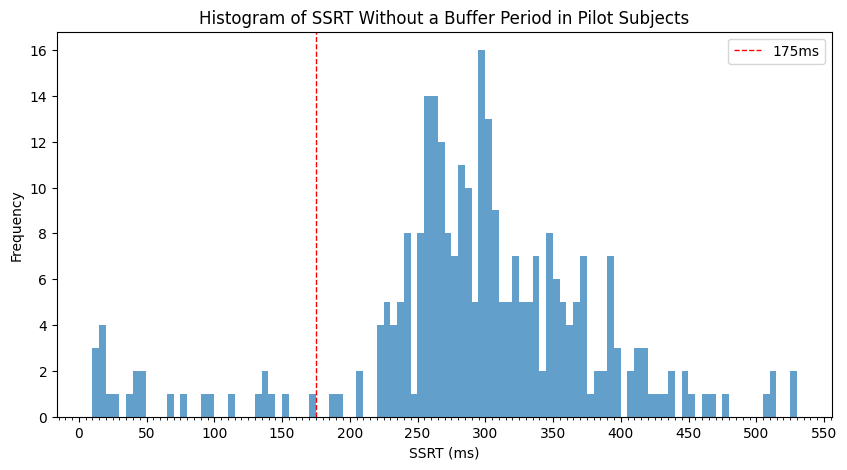

In [39]:
plot_moments_of_inhibition(pilot_files, pilot_data, exp_stage="pilot")

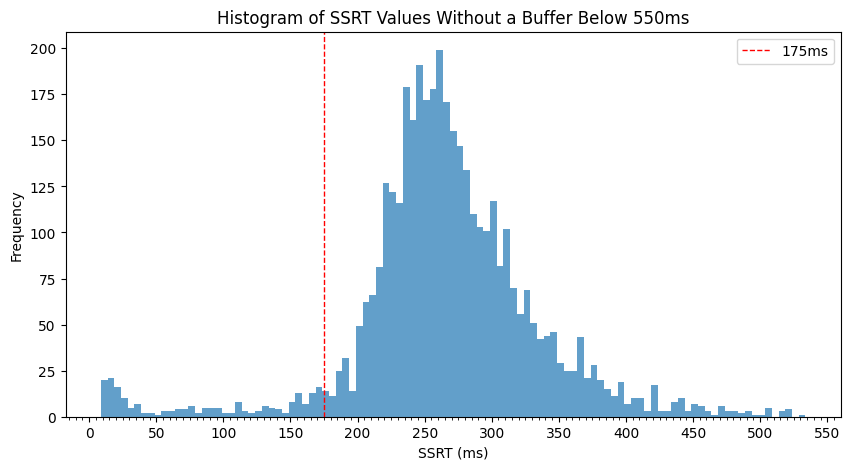

In [40]:
plot_moments_of_inhibition(data_files, data)

## Supplemental Figure 3

In [41]:
survey_directory = os.path.join(parent_directory, 'data', 'surveys', 'final')
surveys = ['ai_survey']
           
participant_mapping = {'22285773-a87e-4a68-a101-66bfd5cca2ed': 's004', 'a14a7c9d-937a-436c-84f1-cd979080ec0b': 's005', 
                       '80e2dc89-dc36-4c85-9028-07a45c0fa569': 's006', '323a83de-05e3-42dd-a975-4d8407f8bf35': 's009', 
                       'f86b2c13-eb4c-47a3-bb45-68b01088e20c': 's008', '518bb4c0-1eb3-454e-9c07-57b7f14a7bc2': 's007', 
                       '69383d84-3462-4b90-b37d-5bc10da0cf1f': 's010', '686fb9b6-423d-4130-82ed-dd94c65b7c71': 's011', 
                       '56a06a94-cbf4-4a97-9b11-c903cc44669d': 's012', '2a894bdd-3a63-4490-82a8-60aa04ff2891': 's013', 
                       '9d16d983-101a-464c-9056-d0526355d134': 's014', '641d914a-7477-480a-9951-c34376399207': 's015', 
                       '63ba282e-0156-45ae-8070-677e8b43be09': 's016', '3854412c-03ce-4be4-82b8-d548ed62c787': 's017', 
                       '06fbed4e-909b-4183-86d8-db2d58716fd5': 's018', '62041c7c-754a-48d4-b5bf-fbddae1c2c6a': 's019', 
                       '78dbfa30-3a9b-478d-982a-aa79d7d6936c': 's020', 'c7f491d8-640b-4dd4-bc11-f028d37d988e': 's021', 
                       '6240a1dc-00dd-482a-a21a-880f973a1064': 's022', '24c3882b-668d-476e-8b26-1f8be338e5e3': 's023', 
                       'd6d87b0e-93a0-4ed4-b167-35ca2247703b': 's024', '9ef17c2a-1a75-40cc-8d51-d543ddb013d6': 's025', 
                       '1eb00119-97bc-45c1-b454-b57b6dcdbddb': 's026', '970ea90c-1365-4622-aed6-31322a2dafa6': 's027', 
                       '5f1d309b-8acb-4d27-8260-8d86185fb1f6': 's028', '24cab759-3bb7-4a22-a68f-24fb8058ed0b': 's029', 
                       '51d6b3f3-753a-4d86-9172-72408101f876': 's030', '98587983-1da1-4fbe-bea0-bcfb58e6db57': 's031', 
                       '061446ad-baa8-4e5e-a3a9-e1d16ced69a5': 's032', 'a72d4062-e4a9-40aa-9a9a-89fca5aa6105': 's033', 
                       '81bf5c8a-11cc-4736-a601-9d9769f615e4': 's034', 'b1a4d269-ab36-4e74-8e00-c579bda18761': 's035', 
                       'd577300b-967e-45d7-a36e-e97f13434035': 's036', 'f1f83835-9d7f-4841-a1bb-3bff8f81f55f': 's037', 
                       'fd1311c6-da0b-44b6-91a9-fdcd08fc5a4b': 's038', 'fa74503f-f470-443d-9125-fbd66a3f2396': 's039', 
                       '315123d0-223b-4db6-b2a7-7f2ff51d907b': 's040', '3048cc74-83c1-445e-bb31-ec9069d6567e': 's041', 
                       '52ce857a-38b4-4ab4-a467-729e0686f2cc': 's042', '06e403ab-ebc3-4fde-965a-733f38a2792f': 's043'}

In [42]:
def correct_reverse_coding(row):
    """
    Correct the scoring of survey responses, particularly for reverse-coded questions.

    Parameters:
    - row: A pandas Series representing a single row of the DataFrame containing the survey data.

    Returns:
    - The corrected response value. If the response is NaN, returns None. 
      If the question is specifically 'ai_survey_5_options', applies reverse coding; 
      otherwise, returns the integer value of the response.
    """
    if pd.isna(row['response']):
        return None
    elif row['question_key'] == 'ai_survey_5_options':
        return 6 - int(row['response'])
    else:
        return int(row['response'])

In [43]:
survey_results = {}
for foldername in os.listdir(survey_directory):
    folder_path = os.path.join(survey_directory, foldername)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                if any(survey in filename for survey in surveys):
                    subject_id = filename.split('_')[0]
                    
                    if subject_id:
                        df = pd.read_csv(os.path.join(folder_path, filename))
                        df['corrected_value'] = df.apply(correct_reverse_coding, axis=1)

                        survey_results[subject_id] = {'data': df, 'average_score': df['corrected_value'].mean(), 
                                                      'total_score': df['corrected_value'].sum()}
                        for question in df['text']:
                            survey_results[subject_id][question] = df.loc[df['text'] == question, 'corrected_value'].values[0]
                
result_df = pd.DataFrame({
    'subject_id': survey_results.keys(),
    'average_score': [details['average_score'] for details in survey_results.values()],
    'total_score': [details['total_score'] for details in survey_results.values()]
})

# Loop through each subject to add question scores to the DataFrame
for subject_id, details in survey_results.items():
    df = details['data']
    for question in df['text']:
        result_df.loc[result_df['subject_id'] == subject_id, question] = details[question]

result_df = result_df.sort_values(by='subject_id')
result_df.to_csv(f'{parent_directory}/output/survey_scores.csv', index=False)

Mapping of Question Numbers to Original Questions:
Q1: AI is making our daily lives easier.
Q2: I believe that increased use of artificial intelligence will make the world a safer place.
Q3: I trust a self driving car to drive safer than I would normally.
Q4: I trust artificial intelligence.
Q5: I trust companies that do not use AI over companies that do.
Q6: I would prefer to drive a self-driving car over a regular car.
Q7: More vehicles, software, and appliances should make use of AI.


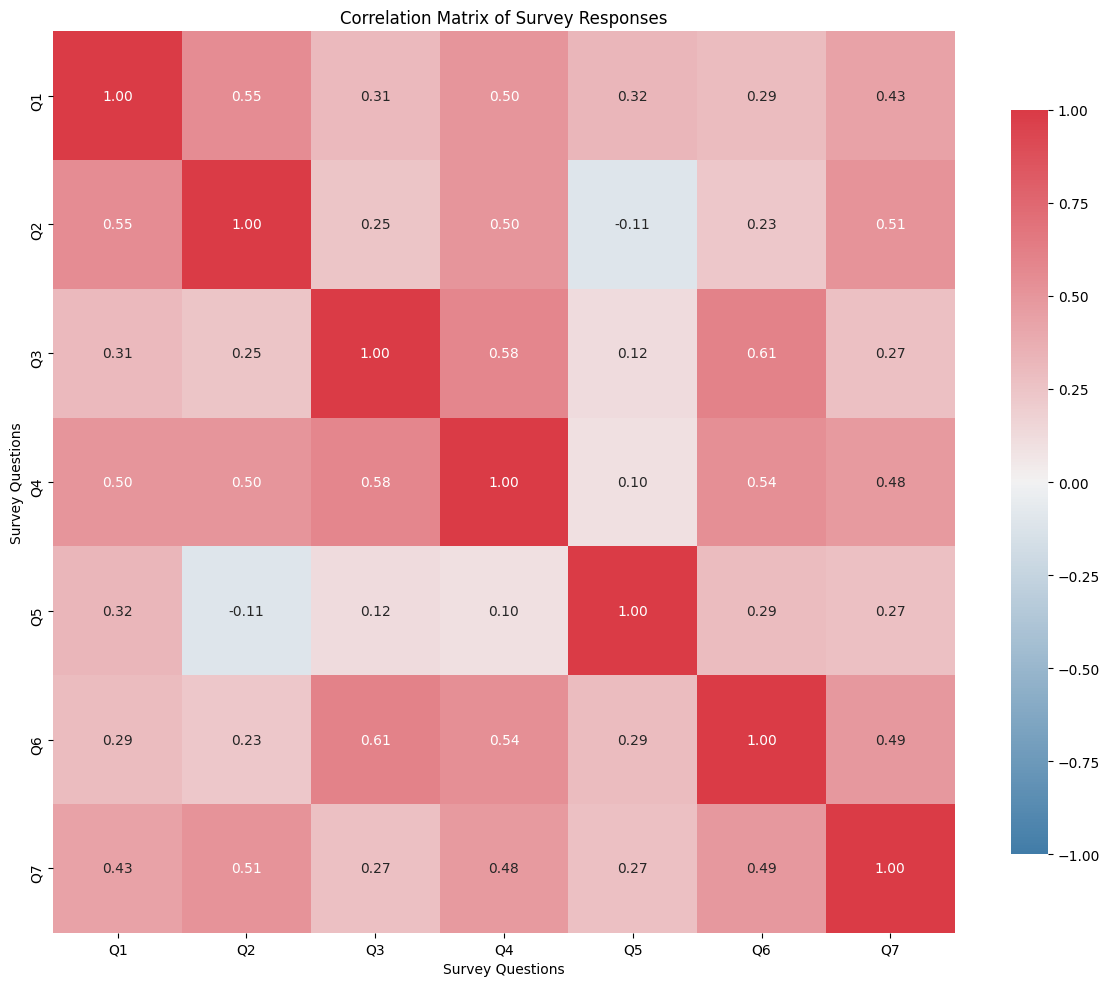

In [44]:
# Step 1: Extract corrected values into a DataFrame
combined_data = []

for subject_id, details in survey_results.items():
    df = details['data']
    for idx, row in df.iterrows():
        combined_data.append({'subject_id': subject_id, 'text': row['text'], 'corrected_value': row['corrected_value']})

# Step 2: Create a pivot DataFrame
pivot_df = pd.DataFrame(combined_data)
pivot_df = pivot_df.pivot(index='subject_id', columns='text', values='corrected_value')

# Step 3: Create a mapping from question number to original questions
question_mapping = {f'Q{i + 1}': question for i, question in enumerate(pivot_df.columns)}

print("Mapping of Question Numbers to Original Questions:")
for q_num, original_question in question_mapping.items():
    print(f"{q_num}: {original_question}")

# Step 4: Rename the columns to Q1, Q2, ..., Q7
new_columns = [f'Q{i + 1}' for i in range(len(pivot_df.columns))]
pivot_df.columns = new_columns

# Step 5: Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Step 6: Create a heatmap of the correlation matrix
cmap = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0, square=True, 
            cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10}) 

plt.title("Correlation Matrix of Survey Responses")
plt.xlabel("Survey Questions")
plt.ylabel("Survey Questions")

tick_positions = np.arange(len(new_columns)) + 0.5
plt.xticks(ticks=tick_positions, labels=new_columns)
plt.yticks(ticks=tick_positions, labels=new_columns)

plt.tight_layout()

plt.savefig(f'{parent_directory}/figures/figureS3.png', dpi=300) 
plt.show()